In [ ]:
!unzip "/content/drive/MyDrive/zipped.zip" -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflatin

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set seed for reproducibility
import random
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


Num GPUs Available:  0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base_dir as empty since full path is already provided
base_dir = ""

# Correct paths
train_dir = os.path.join(base_dir, "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")
validation_dir = os.path.join(base_dir, "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid")

# Define ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

# Update generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # still use train_dir because split is internal
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)


Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.


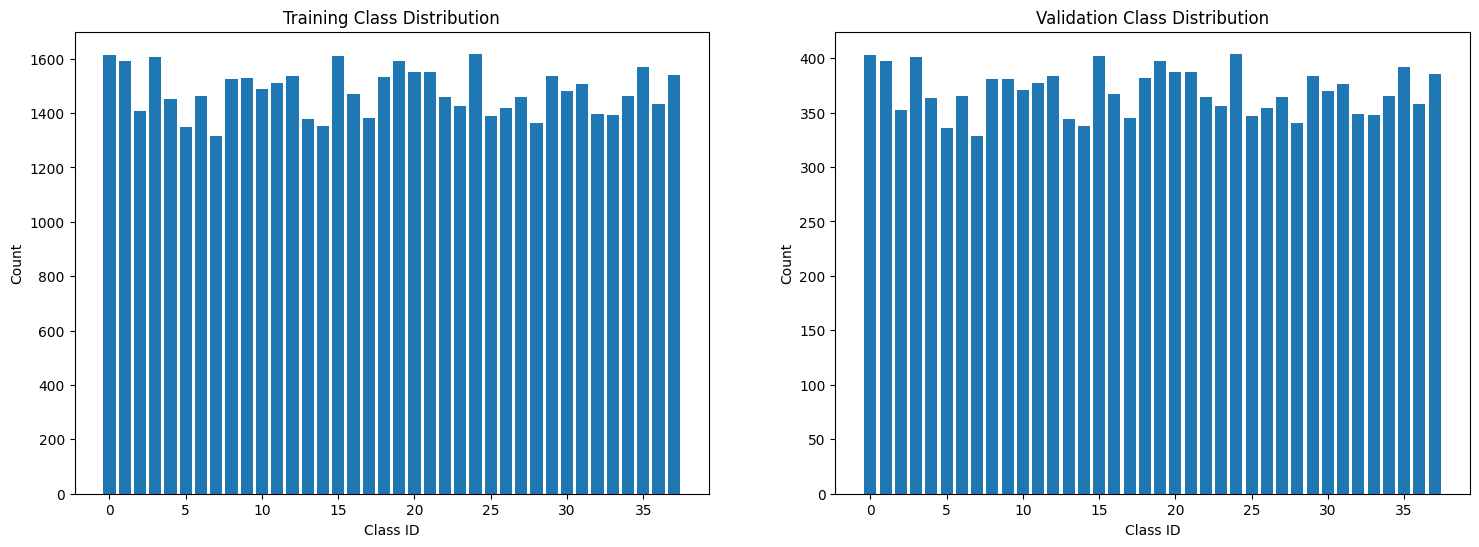

In [ ]:
# Get class counts for training and validation
train_classes = np.unique(train_generator.classes, return_counts=True)
val_classes = np.unique(validation_generator.classes, return_counts=True)

# Plot class distributions
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.bar(train_classes[0], train_classes[1])
plt.title("Training Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.bar(val_classes[0], val_classes[1])
plt.title("Validation Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

In [ ]:
# Get class names and counts for training and validation
train_class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))
val_class_counts = dict(zip(validation_generator.class_indices.keys(), np.bincount(validation_generator.classes)))

# Check for classes with <100 samples in training/validation
under_100_train = {cls: count for cls, count in train_class_counts.items() if count < 100}
under_100_val = {cls: count for cls, count in val_class_counts.items() if count < 100}

# Compare validation vs training distribution
distribution_diff = {}
for cls in train_class_counts:
    train_count = train_class_counts[cls]
    val_count = val_class_counts.get(cls, 0)
    diff_pct = abs(val_count - (train_count * 0.05)) / (train_count * 0.05) * 100  # Assuming 5% validation split
    distribution_diff[cls] = diff_pct

# Print results
print("=== Class Analysis ===")
print(f"\nClasses with <100 training samples ({len(under_100_train)}):")
for cls, count in under_100_train.items():
    print(f"  - {cls}: {count} samples")

print(f"\nClasses with <100 validation samples ({len(under_100_val)}):")
for cls, count in under_100_val.items():
    print(f"  - {cls}: {count} samples")

print("\nValidation-Training Distribution Similarity:")
for cls, diff in distribution_diff.items():
    status = "WARNING: >10% difference" if diff > 10 else "OK"
    print(f"  - {cls}: {diff:.1f}% difference | {status}")

print("\nSummary Statistics:")
print(f"Total training samples: {sum(train_class_counts.values())}")
print(f"Total validation samples: {sum(val_class_counts.values())}")
print(f"Average samples per class (train): {np.mean(list(train_class_counts.values())):.1f}")
print(f"Average samples per class (val): {np.mean(list(val_class_counts.values())):.1f}")

=== Class Analysis ===

Classes with <100 training samples (0):

Classes with <100 validation samples (0):

Validation-Training Distribution Similarity:
  - Apple___Apple_scab: 399.7% difference | WARNING: >10% difference
  - Apple___Black_rot: 399.4% difference | WARNING: >10% difference
  - Apple___Cedar_apple_rust: 400.0% difference | WARNING: >10% difference
  - Apple___healthy: 399.1% difference | WARNING: >10% difference
  - Blueberry___healthy: 399.7% difference | WARNING: >10% difference
  - Cherry_(including_sour)___Powdery_mildew: 398.9% difference | WARNING: >10% difference
  - Cherry_(including_sour)___healthy: 399.7% difference | WARNING: >10% difference
  - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 399.2% difference | WARNING: >10% difference
  - Corn_(maize)___Common_rust_: 399.3% difference | WARNING: >10% difference
  - Corn_(maize)___Northern_Leaf_Blight: 399.0% difference | WARNING: >10% difference
  - Corn_(maize)___healthy: 398.7% difference | WARNING: >1

In [ ]:
# Replace your validation generator setup with this:
validation_dir = os.path.join(base_dir, "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid")  # Confirm this path matches your actual validation folder

# Use a SEPARATE generator for validation (no subset splitting)
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,  # Directly use validation folder (not a subset of training)
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep order for proper evaluation
)

Found 17572 images belonging to 38 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
train_classes = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_classes), y=train_classes)
class_weights = dict(enumerate(class_weights))

# Add to model.fit() later

In [ ]:
# Remove the tensorflow-addons code and use standard augmentation
# Update your ImageDataGenerator with more aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Recreate generators with corrected validation path (no subset split)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    seed=seed
)

validation_dir = os.path.join(base_dir, "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid")
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for consistent evaluation
)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_generator.classes),
                                    y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

print("\nClass weights for imbalanced training:", class_weights)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.

Class weights for imbalanced training: {0: np.float64(0.917593462823726), 1: np.float64(0.9309856170370566), 2: np.float64(1.0510616028708133), 3: np.float64(0.9212492136716293), 4: np.float64(1.0186500115928587), 5: np.float64(1.0991493886230728), 6: np.float64(1.013071424453796), 7: np.float64(1.1265946535034297), 8: np.float64(0.9700411227334198), 9: np.float64(0.9695327154363897), 10: np.float64(0.9950879080433737), 11: np.float64(0.9798031891168599), 12: np.float64(0.9634731359649122), 13: np.float64(1.074255761354606), 14: np.float64(1.0933028493218864), 15: np.float64(0.9203325477873789), 16: np.float64(1.006457247580322), 17: np.float64(1.0705257066276803), 18: np.float64(0.9669986518832365), 19: np.float64(0.9305173144127925), 20: np.float64(0.9540321923943432), 21: np.float64(0.9540321923943432), 22: np.float64(1.0141822483841183), 23: np.float64(1.038668400366441), 24: np.float64(0.91487

In [ ]:
def build_model():
    # Fix the parenthesis and input shape
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3)  # Closing parenthesis added here
    )
    base_model.trainable = False  # Freeze pretrained layers

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(38, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [ ]:
model = build_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,388,297 (16.74 MB)

 Trainable params: 338,214 (1.29 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths (confirm these match your dataset structure)
base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

# ========== DATA GENERATORS ==========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# ========== CALLBACKS ==========
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

# ========== TRAIN THE MODEL ==========
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,  # Ensure class_weights is defined
    verbose=1
)

# ========== EVALUATE ==========
model.load_weights('best_model.h5')  # Load best checkpoint
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nValidation Accuracy: {val_acc:.2%}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Epoch 1/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3514 - loss: 3.0441

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 416s 368ms/step - accuracy: 0.3516 - loss: 3.0433 - val_accuracy: 0.7769 - val_loss: 1.1668
Epoch 2/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7356 - loss: 1.2636

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 368s 335ms/step - accuracy: 0.7356 - loss: 1.2635 - val_accuracy: 0.8284 - val_loss: 0.9305
Epoch 3/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7939 - loss: 1.0286

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 366s 333ms/step - accuracy: 0.7939 - loss: 1.0286 - val_accuracy: 0.8530 - val_loss: 0.8038
Epoch 4/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8220 - loss: 0.8845

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 361s 328ms/step - accuracy: 0.8220 - loss: 0.8845 - val_accuracy: 0.8656 - val_loss: 0.7172
Epoch 5/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8363 - loss: 0.7975

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 358s 326ms/step - accuracy: 0.8363 - loss: 0.7975 - val_accuracy: 0.8714 - val_loss: 0.6591
Epoch 6/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8473 - loss: 0.7352

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 364s 331ms/step - accuracy: 0.8473 - loss: 0.7352 - val_accuracy: 0.8802 - val_loss: 0.6111
Epoch 7/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8580 - loss: 0.6753

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 360s 328ms/step - accuracy: 0.8580 - loss: 0.6753 - val_accuracy: 0.8809 - val_loss: 0.5864
Epoch 8/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8653 - loss: 0.6274

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 384s 330ms/step - accuracy: 0.8653 - loss: 0.6274 - val_accuracy: 0.8902 - val_loss: 0.5348
Epoch 9/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8690 - loss: 0.6007

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 376s 324ms/step - accuracy: 0.8690 - loss: 0.6007 - val_accuracy: 0.8929 - val_loss: 0.5118
Epoch 10/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8732 - loss: 0.5693

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 366s 333ms/step - accuracy: 0.8732 - loss: 0.5693 - val_accuracy: 0.8968 - val_loss: 0.4867
Epoch 11/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 357s 325ms/step - accuracy: 0.8766 - loss: 0.5524 - val_accuracy: 0.8935 - val_loss: 0.4872
Epoch 12/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 356s 324ms/step - accuracy: 0.8810 - loss: 0.5268 - val_accuracy: 0.8908 - val_loss: 0.4811
Epoch 13/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 351s 320ms/step - accuracy: 0.8818 - loss: 0.5149 - val_accuracy: 0.8906 - val_loss: 0.4719
Epoch 14/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8857 - loss: 0.4967

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 356s 324ms/step - accuracy: 0.8857 - loss: 0.4967 - val_accuracy: 0.8978 - val_loss: 0.4453
Epoch 15/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8855 - loss: 0.4840

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 357s 325ms/step - accuracy: 0.8855 - loss: 0.4840 - val_accuracy: 0.8979 - val_loss: 0.4376
Epoch 16/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8888 - loss: 0.4667

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 356s 324ms/step - accuracy: 0.8888 - loss: 0.4667 - val_accuracy: 0.9015 - val_loss: 0.4247
Epoch 17/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 354s 322ms/step - accuracy: 0.8889 - loss: 0.4640 - val_accuracy: 0.8963 - val_loss: 0.4318
Epoch 18/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8907 - loss: 0.4556

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 364s 331ms/step - accuracy: 0.8907 - loss: 0.4556 - val_accuracy: 0.9057 - val_loss: 0.3976
Epoch 19/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8929 - loss: 0.4390

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 356s 324ms/step - accuracy: 0.8929 - loss: 0.4390 - val_accuracy: 0.9060 - val_loss: 0.3936
Epoch 20/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 352s 320ms/step - accuracy: 0.8961 - loss: 0.4309 - val_accuracy: 0.9050 - val_loss: 0.3957
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9416 - loss: 0.2907

Validation Accuracy: 90.60%


In [ ]:
# Unfreeze the base model layers
base_model = model.layers[0]
base_model.trainable = True

# Freeze first 100 layers, unfreeze the rest (adjust based on your model depth)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Very low LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train for 10 more epochs
fine_tune_epochs = 10
total_epochs = 20 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('fine_tuned_model.h5', save_best_only=True)
    ],
    class_weight=class_weights,
    verbose=1
)

Epoch 20/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7107 - loss: 1.0990

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 408s 351ms/step - accuracy: 0.7108 - loss: 1.0988 - val_accuracy: 0.8771 - val_loss: 0.4951
Epoch 21/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8531 - loss: 0.5642

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 372s 338ms/step - accuracy: 0.8531 - loss: 0.5642 - val_accuracy: 0.8910 - val_loss: 0.4315
Epoch 22/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8894 - loss: 0.4431

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 371s 338ms/step - accuracy: 0.8894 - loss: 0.4430 - val_accuracy: 0.9087 - val_loss: 0.3792
Epoch 23/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9092 - loss: 0.3788

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 365s 332ms/step - accuracy: 0.9092 - loss: 0.3788 - val_accuracy: 0.9157 - val_loss: 0.3598
Epoch 24/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9189 - loss: 0.3501

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 364s 331ms/step - accuracy: 0.9189 - loss: 0.3501 - val_accuracy: 0.9235 - val_loss: 0.3296
Epoch 25/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9319 - loss: 0.3141

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 363s 331ms/step - accuracy: 0.9319 - loss: 0.3141 - val_accuracy: 0.9323 - val_loss: 0.3080
Epoch 26/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9369 - loss: 0.2927

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 365s 332ms/step - accuracy: 0.9369 - loss: 0.2927 - val_accuracy: 0.9402 - val_loss: 0.2817
Epoch 27/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9452 - loss: 0.2683

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 357s 325ms/step - accuracy: 0.9452 - loss: 0.2683 - val_accuracy: 0.9407 - val_loss: 0.2767
Epoch 28/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9500 - loss: 0.2556

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 389s 331ms/step - accuracy: 0.9500 - loss: 0.2556 - val_accuracy: 0.9461 - val_loss: 0.2640
Epoch 29/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9545 - loss: 0.2386

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 362s 329ms/step - accuracy: 0.9545 - loss: 0.2386 - val_accuracy: 0.9449 - val_loss: 0.2626
Epoch 30/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9589 - loss: 0.2258

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 359s 327ms/step - accuracy: 0.9589 - loss: 0.2258 - val_accuracy: 0.9545 - val_loss: 0.2337


In [ ]:
base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")


In [ ]:
# Use validation set as test (temporary workaround)
test_dir = valid_dir  # Replace with your actual test path when available

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),  # Must match training size
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Critical for correct evaluation
)

print("Test classes:", test_generator.class_indices)

Found 17572 images belonging to 38 classes.
Test classes: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomat

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Update with your actual test directory
test_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test_generator.class_indices.keys())

Found 17572 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


550/550 ━━━━━━━━━━━━━━━━━━━━ 276s 490ms/step


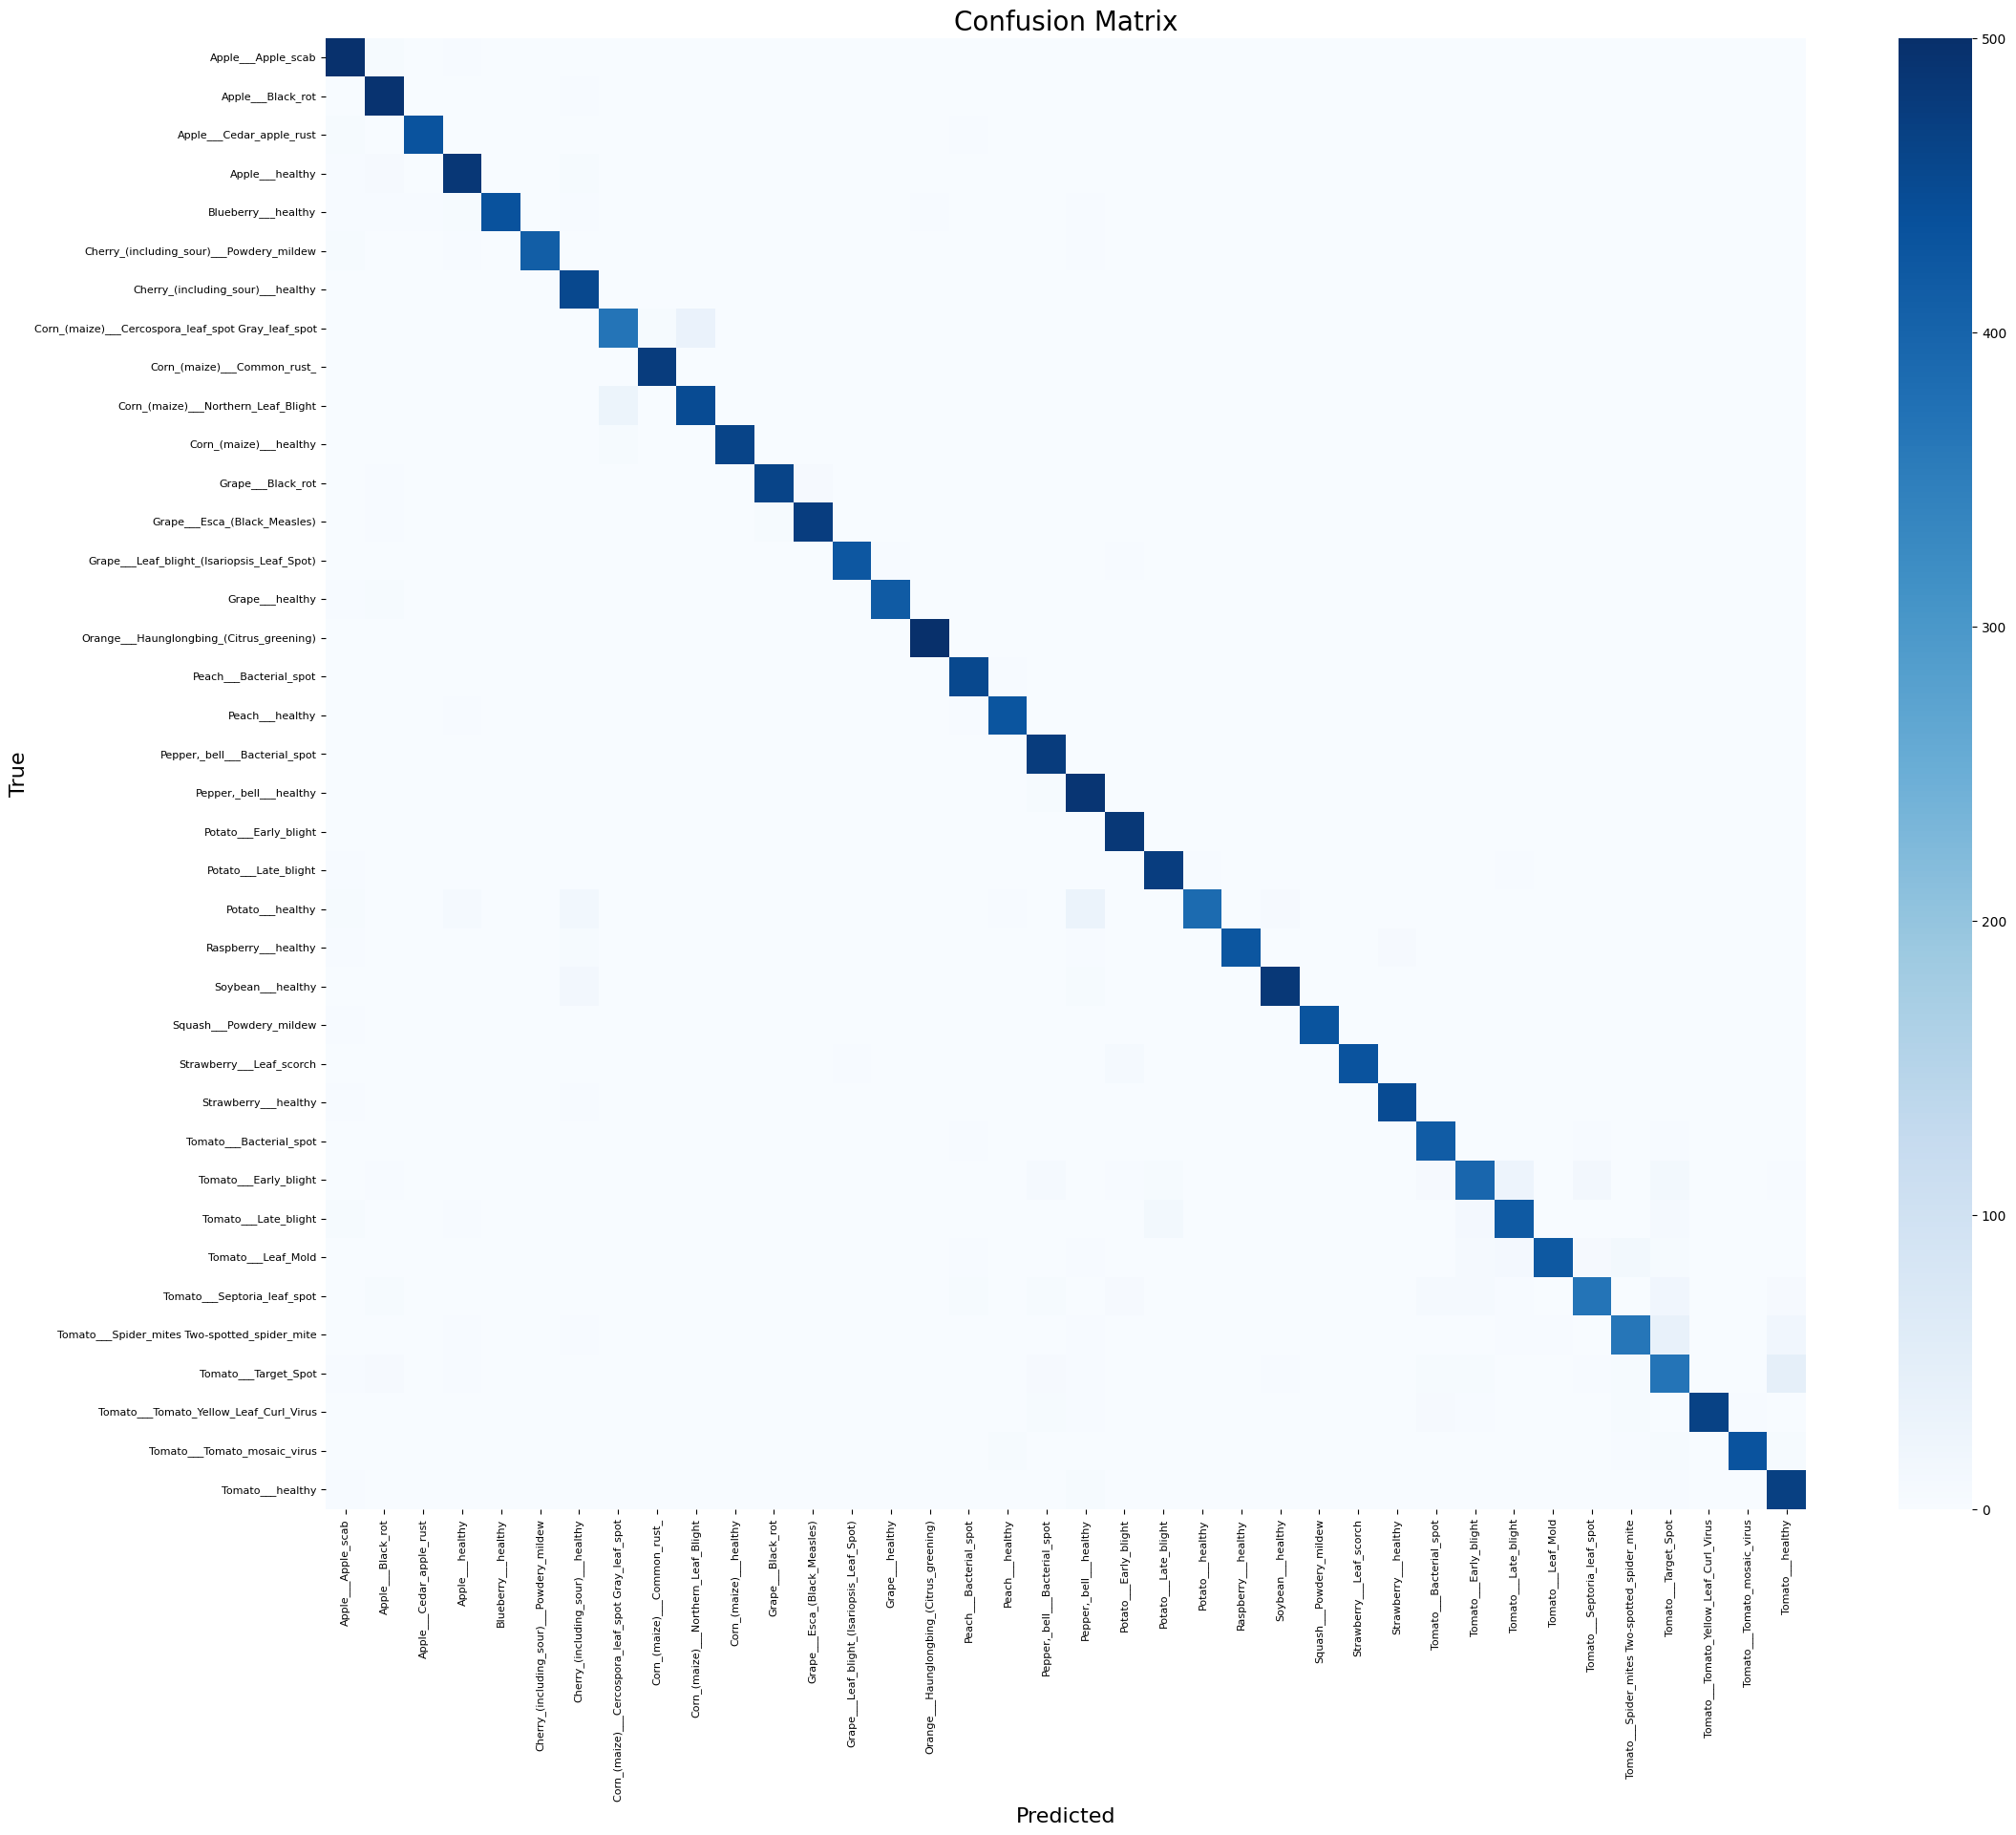

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions
model = tf.keras.models.load_model('fine_tuned_model.h5')
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(25,20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Simplified Metrics
print("\nSummary Metrics:")
print(f"Overall Accuracy: {np.mean(y_true == y_pred):.2%}")
print(f"Macro F1-Score: {f1_score(y_true, y_pred, average='macro'):.2%}")

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.919     0.986     0.951       504
                                 Apple___Black_rot      0.930     0.994     0.961       497
                          Apple___Cedar_apple_rust      0.986     0.982     0.984       440
                                   Apple___healthy      0.944     0.966     0.955       502
                               Blueberry___healthy      0.998     0.956     0.976       454
          Cherry_(including_sour)___Powdery_mildew      1.000     0.979     0.989       421
                 Cherry_(including_sour)___healthy      0.894     0.998     0.943       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.918     0.900     0.909       410
                       Corn_(maize)___Common_rust_      0.990     0.996     0.993       477
               Corn_(maize)___Northern_Leaf_Blight      

In [ ]:
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i,j] > 1:
            confused_pairs.append((cm[i,j], class_names[i], class_names[j]))

print("Top 10 Confusions:")
for count, true, pred in sorted(confused_pairs, reverse=True)[:10]:
    print(f"{true} → {pred}: {count} errors")

Top 10 Confusions:
Tomato___Target_Spot → Tomato___healthy: 45 errors
Tomato___Spider_mites Two-spotted_spider_mite → Tomato___Target_Spot: 38 errors
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot → Corn_(maize)___Northern_Leaf_Blight: 35 errors
Potato___healthy → Pepper,_bell___healthy: 30 errors
Corn_(maize)___Northern_Leaf_Blight → Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 28 errors
Tomato___Early_blight → Tomato___Late_blight: 27 errors
Tomato___Spider_mites Two-spotted_spider_mite → Tomato___healthy: 19 errors
Tomato___Septoria_leaf_spot → Tomato___Target_Spot: 19 errors
Potato___healthy → Cherry_(including_sour)___healthy: 17 errors
Tomato___Early_blight → Tomato___Septoria_leaf_spot: 15 errors


In [ ]:
class_acc = {class_names[i]: np.mean(y_pred[y_true == i] == i) for i in range(len(class_names))}

print("Worst 5 Performing Classes:")
for cls, acc in sorted(class_acc.items(), key=lambda x: x[1])[:5]:
    print(f"{cls:<40} Accuracy: {acc:.2%}")

Worst 5 Performing Classes:
Tomato___Target_Spot                     Accuracy: 80.74%
Tomato___Early_blight                    Accuracy: 82.29%
Tomato___Spider_mites Two-spotted_spider_mite Accuracy: 83.91%
Potato___healthy                         Accuracy: 84.43%
Tomato___Septoria_leaf_spot              Accuracy: 84.63%


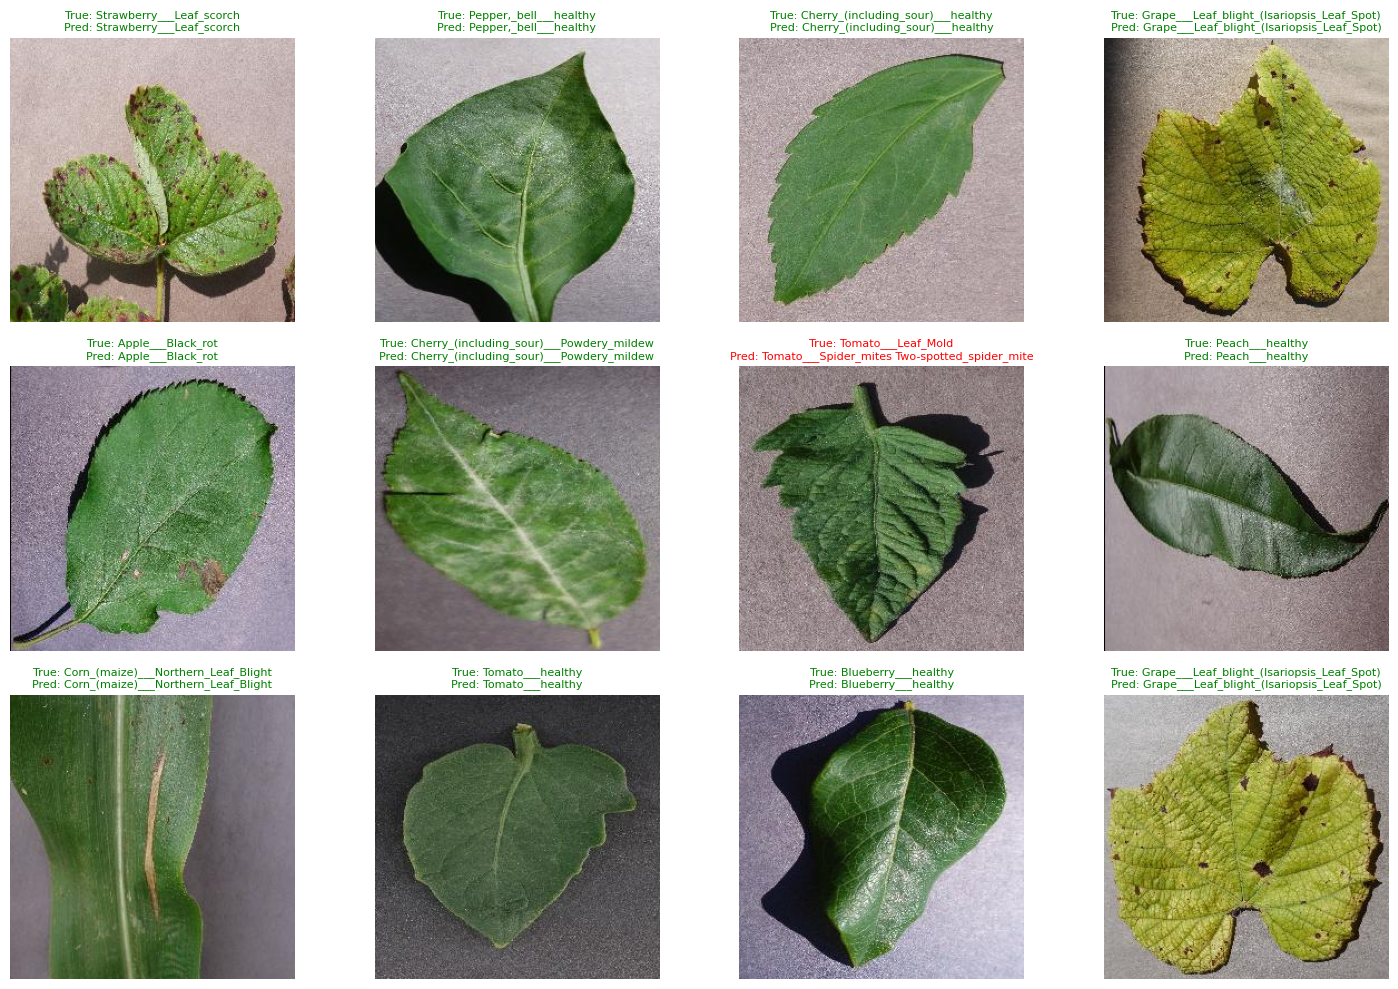

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    idx = np.random.choice(len(test_generator.filepaths))
    img = plt.imread(test_generator.filepaths[idx])
    plt.imshow(img)
    true_cls = class_names[y_true[idx]]
    pred_cls = class_names[y_pred[idx]]
    color = 'green' if true_cls == pred_cls else 'red'
    plt.title(f"True: {true_cls}\nPred: {pred_cls}", color=color, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Get predicted probabilities
y_probs = model.predict(test_generator)

# One-hot encode true labels
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_true_bin, y_probs, multi_class='ovr')
print(f"ROC AUC (One-vs-Rest): {roc_auc:.4f}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 296s 537ms/step
ROC AUC (One-vs-Rest): 0.9996


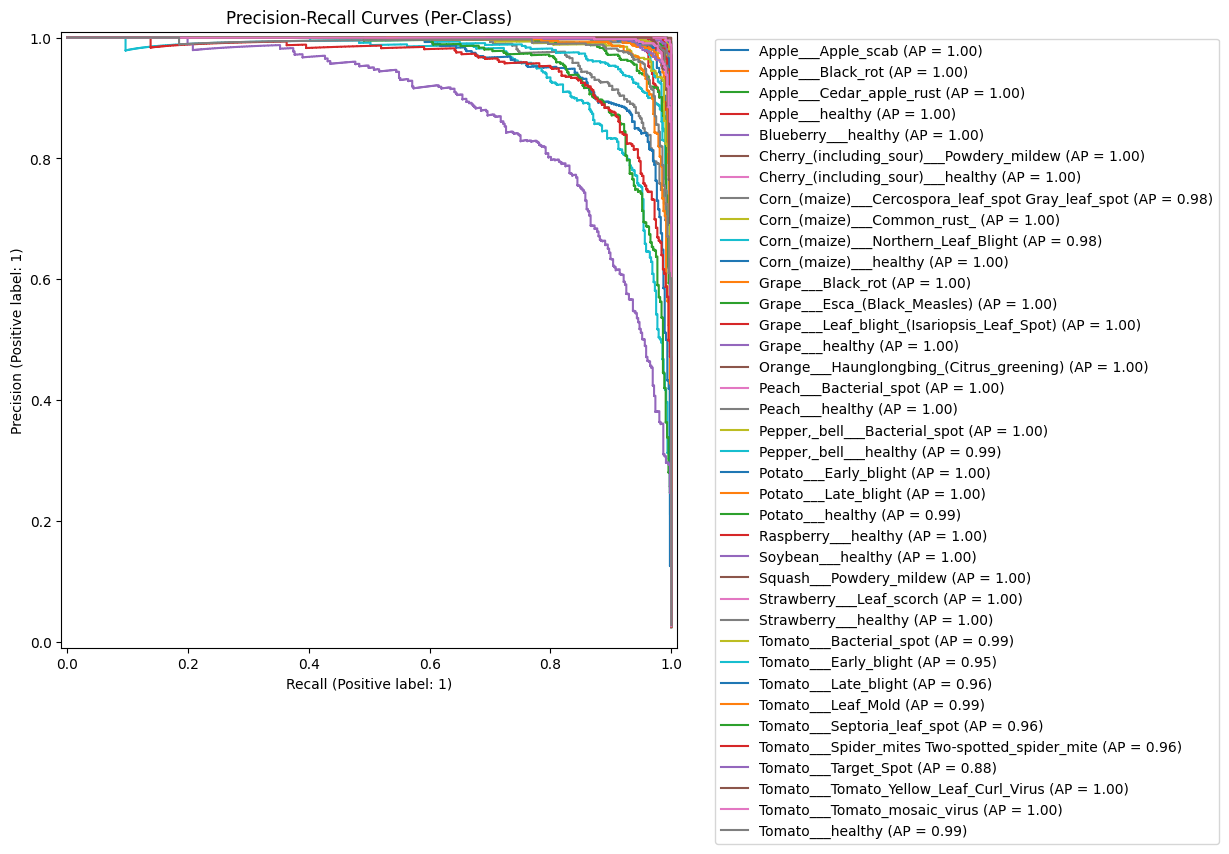

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    PrecisionRecallDisplay.from_predictions(
        y_true_bin[:,i], y_probs[:,i],
        name=f"{class_names[i]}",
        ax=plt.gca()
    )
plt.title("Precision-Recall Curves (Per-Class)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
top_k = 2  # Try with 3 for more insights
sorted_preds = np.argsort(y_probs, axis=1)[:, -top_k:]
top_k_acc = np.mean([y_true[i] in sorted_preds[i] for i in range(len(y_true))])
print(f"Top-{top_k} Accuracy: {top_k_acc:.2%}")

Top-2 Accuracy: 98.86%


In [ ]:
class_roc_auc = {}
for i in range(len(class_names)):
    class_roc_auc[class_names[i]] = roc_auc_score(
        (y_true == i).astype(int), y_probs[:,i]
    )

print("Class-wise ROC AUC:")
for cls, auc in sorted(class_roc_auc.items(), key=lambda x: x[1]):
    print(f"{cls:<35}: {auc:.4f}")

Class-wise ROC AUC:
Tomato___Target_Spot               : 0.9954
Tomato___Early_blight              : 0.9978
Tomato___Septoria_leaf_spot        : 0.9983
Tomato___Late_blight               : 0.9985
Tomato___Spider_mites Two-spotted_spider_mite: 0.9988
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.9992
Tomato___Leaf_Mold                 : 0.9995
Corn_(maize)___Northern_Leaf_Blight: 0.9996
Tomato___healthy                   : 0.9996
Potato___healthy                   : 0.9996
Pepper,_bell___healthy             : 0.9998
Tomato___Bacterial_spot            : 0.9998
Apple___Apple_scab                 : 0.9999
Apple___healthy                    : 0.9999
Potato___Late_blight               : 0.9999
Soybean___healthy                  : 0.9999
Apple___Black_rot                  : 0.9999
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.9999
Grape___Esca_(Black_Measles)       : 0.9999
Strawberry___healthy               : 0.9999
Tomato___Tomato_mosaic_virus       : 1.0000
Pepper,_bell___Bacterial_spo

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")
# Interpretation:
# <0: No agreement
# 0-0.2: Slight
# 0.2-0.4: Fair
# 0.4-0.6: Moderate
# 0.6-0.8: Substantial
# 0.8-1: Almost perfect

Cohen's Kappa: 0.9532


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
# Range: -1 (worst) to 1 (best)

Matthews Correlation Coefficient: 0.9533


In [ ]:
import time

# Warmup
model.predict(np.random.rand(1, 128, 128, 3))

# CPU Benchmark
times = []
for _ in range(50):
    img = np.random.rand(1, 128, 128, 3)
    start = time.time()
    model.predict(img)
    times.append(time.time() - start)

print(f"Average Inference Time: {np.mean(times):.4f}s ± {np.std(times):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

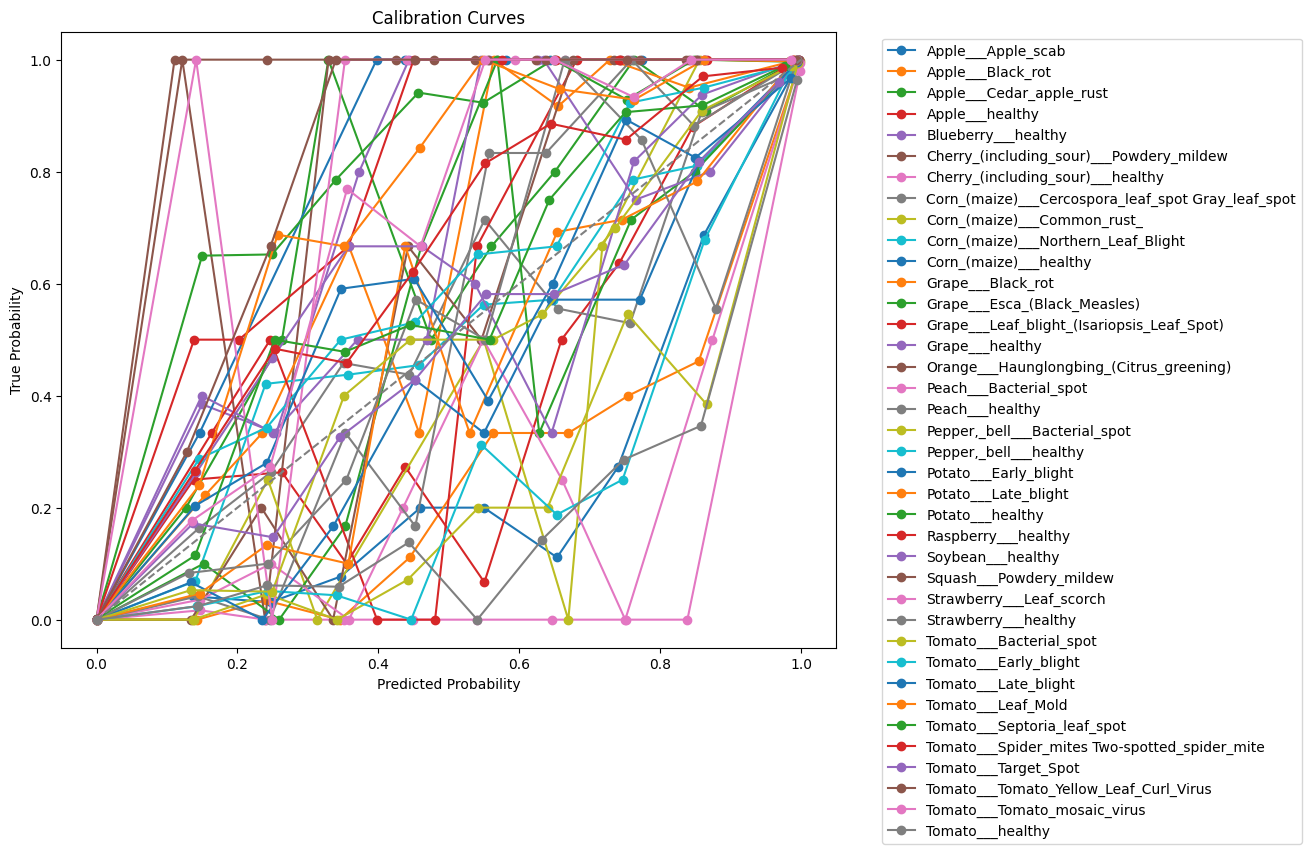

In [ ]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    prob_true, prob_pred = calibration_curve(
        (y_true == i), y_probs[:,i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=class_names[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
def test_robustness(image, perturbations):
    """Test model against various image transformations"""
    original_pred = class_names[np.argmax(model.predict(image))]

    results = {}
    for name, func in perturbations.items():
        perturbed = func(image)
        pred = class_names[np.argmax(model.predict(perturbed))]
        results[name] = (pred, pred == original_pred)

    return results

# Example usage
test_image = next(test_generator)[0][0:1]  # Get first image
perturbations = {
    'Rotation': lambda x: tf.image.rot90(x),
    'Noise': lambda x: x + 0.1*tf.random.normal(x.shape),
    'Flip': lambda x: tf.image.flip_left_right(x)
}

robustness_results = test_robustness(test_image, perturbations)
print("Robustness Test Results:", robustness_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Robustness Test Results: {'Rotation': ('Apple___Apple_scab', True), 'Noise': ('Apple___Apple_scab', True), 'Flip': ('Apple___Apple_scab', True)}
